<a href="https://colab.research.google.com/github/garrettsomers/ManningLLMBook/blob/chapter3/notebooks/Chapter_3-Named_Entity_Recognition_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install datasets
!pip install openprompt

In [8]:
import copy
import torch
import numpy as np
import pandas as pd

use_cuda = torch.cuda.is_available()

In [ ]:
## DATA LOADING

In [ ]:
from datasets import load_dataset, Dataset

# load CoNLL-2003 dataset from huggingface
dataset = load_dataset('conll2003')

# create dictionary key for CoNLL-2003 NER-tags:
id_to_label = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}
label_to_id = {0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC', 7: 'B-MISC', 8: 'I-MISC' }

In [ ]:
from transformers import AutoTokenizer

# prepare the data using three steps.
#   1) downsample train, test, val as desired.
#   2) convert labels from dataset tokenization to BERT tokenization
#   3) tokenize and pad the sentences.

seed = 13

TRN_SAMP = 1024
VAL_SAMP = 500

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
SET_EXTRA_TOK_TO_MINUS_100 = False

pad_length = 128

#######

# tokenize sentences and return vectors necessary for the training loop
def tokenize_function(tokens):
    return tokenizer.encode_plus(tokens,
                                 is_split_into_words = True,
                                 pad_to_max_length = True,
                                 max_length = pad_length,
                                 return_attention_mask = True,
                                 return_token_type_ids = True,
                                 )
    
# add BERT-style padding to label vector
def pad_label_example(tokenized_input, labels, label_all_tokens=True):
  # Look for tokens identified as "None" type -- set label to -100. Else,
  # use the label from the input label vector.
  word_ids = tokenized_input.word_ids()
  label_ids = []
  for i, word_idx in enumerate(word_ids):
    if word_idx is None:
      label_ids.append(-100)
    else:
      label_ids.append(labels[i-1])  
  return label_ids

# determine for each word if BERT tokenization differs.
def apply_bert_tok(og_tok_sent,og_lab):
  newlab = []
  ## Determine the tokenization for each word.
  for i, t in enumerate(og_tok_sent):
    ttok = tokenizer(' '+t+' ',add_special_tokens=False)['input_ids']
    ## If the word splits to subwork tokens, extra spots in the labels.
    for j in range(len(ttok)):
      ## Can either set to -100 or set to same label as the original token.
      if SET_EXTRA_TOK_TO_MINUS_100: 
        if j == 0: newlab.append(og_lab[i])
        else: newlab.append(-100)
      else:
        newlab.append(og_lab[i])
  return newlab

## Convert labels to BERT tokenization.
## Note the data comes pretokenized, but the split doesn't match BERT procedure.
## So we tokenize every individual word to determine where word splitting occurs,
## and create a new label vector to account for this.
def bert_token_maker(dataset):
  full_sents, tok_sents, pad_labs = [], [], []
  input_ids, tkntype_ids, attn_masks = [], [], []
  ## Update labels to reflect BERT tokenization
  sents, labs = dataset['sentence'], dataset['labels']
  new_labs = [apply_bert_tok(sents[i], labs[i]) for i in range(len(labs))]
  ## Create encoded dictionaries for each sentence.
  tok_dicts = [tokenize_function(s) for s in sents]

  for td,l in zip(tok_dicts,new_labs):
    ## Collect the original and tokenized sentence.
    full_sents.append(tokenizer.decode(td['input_ids'],skip_special_tokens=True))
    tok_sents.append([tokenizer.decode(td['input_ids'][i]) for i in range(len(td['input_ids']))])
    ## Pad labels to align with tokenized sentences. 
    pad_labs.append(pad_label_example(td,l))
    ## Collect other training requirements. 
    input_ids.append(td['input_ids'])
    tkntype_ids.append(td['token_type_ids'])
    attn_masks.append(td['attention_mask'])

  dataset = Dataset.from_dict(
      {'id': dataset['id'],
       'sentence': full_sents,
       'tokens': tok_sents,
       'labels': pad_labs,
       'input_ids': input_ids,
       'token_type_ids': tkntype_ids,
       'attention_mask': attn_masks
       })

  return dataset

def data_prep(dataset):

    ## Remove unneeded columns
    dataset = dataset.remove_columns(["pos_tags", "chunk_tags"])
    dataset = dataset.rename_column("tokens", "sentence")
    dataset = dataset.rename_column("ner_tags", "labels")

    ## Downsample to a (pseudo)random subset.
    dataset['train'] = dataset['train'].shuffle(seed=seed).select(range(TRN_SAMP))
    dataset['validation'] = dataset['validation'].shuffle(seed=seed).select(range(VAL_SAMP))

    ## Tokenize sentences and align labels.
    dataset['train'] = bert_token_maker(dataset['train'])
    dataset['validation'] = bert_token_maker(dataset['validation'])

    return dataset

tokenized_datasets = data_prep(dataset)

In [5]:
# we will try different numbers of samples for the learning curve
shot_increments = 7
sample_sizes = [0,] + [2**i for i in range(3, 4 + shot_increments)]
sample_sizes

[0, 8, 16, 32, 64, 128, 256, 512, 1024]

In [ ]:
## START OF FINETUNE

In [ ]:
# define F1-score metric
def compute_ptft_f1(preds,labs):
  preds_clean = preds.argmax(axis=2)[labs != -100]
  labs_clean = labs[labs != -100]
  # precision
  pmask = np.isin(preds_clean, [1,3,5,7])
  p = (preds_clean[pmask] == labs_clean[pmask])
  p = p.astype(float).sum()/sum(pmask)
  # recall
  rmask = np.isin(labs_clean, [1,3,5,7])
  r = (preds_clean[rmask] == labs_clean[rmask])
  r = r.astype(float).sum()/sum(rmask)
  # f1
  return 2.*p*r/(p+r)

In [ ]:
from transformers import Trainer, TrainingArguments, BertForTokenClassification, DataCollatorWithPadding

# set parameters for training loop, and load BERT model

tokenized_datasets.set_format("torch")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
training_args = TrainingArguments("trainer")
model = BertForTokenClassification.from_pretrained('bert-base-cased',
                                                    num_labels=len(label_to_id))


# loop over different samples of k
finetune_scores = []
for i, k in enumerate(sample_sizes):
  if k == 0: samps = range(0) ## zero-shot
  else: samps = range(sample_sizes[i-1],k) ## iterative training
  train_sample = tokenized_datasets['train'].select(samps)
  training_args = TrainingArguments("trainer")
  if use_cuda:
    model = model.cuda()
  
  trainer = Trainer(
    model,
    training_args,
    train_dataset=train_sample,
    data_collator=data_collator,
    tokenizer=tokenizer
  )

  # if k==0, do zero-shot testing. Otherwise, activate training.
  if k > 0: 
    trainer.train()
  preds = trainer.predict(tokenized_datasets['validation'])
  f1 = compute_ptft_f1(preds.predictions, preds.label_ids)
  finetune_scores.append(f1)
  print(finetune_scores)
  torch.cuda.empty_cache()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

[0.06870229007633588]


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss


[0.06870229007633588, 0.049224544841537425]


Step,Training Loss


[0.06870229007633588, 0.049224544841537425, 0.0022522522522522522]


Step,Training Loss


[0.06870229007633588, 0.049224544841537425, 0.0022522522522522522, 0.003370786516853933]


Step,Training Loss


[0.06870229007633588, 0.049224544841537425, 0.0022522522522522522, 0.003370786516853933, 0.3323353293413174]


Step,Training Loss


[0.06870229007633588, 0.049224544841537425, 0.0022522522522522522, 0.003370786516853933, 0.3323353293413174, 0.5577981651376147]


Step,Training Loss


[0.06870229007633588, 0.049224544841537425, 0.0022522522522522522, 0.003370786516853933, 0.3323353293413174, 0.5577981651376147, 0.7157034442498541]


Step,Training Loss


[0.06870229007633588, 0.049224544841537425, 0.0022522522522522522, 0.003370786516853933, 0.3323353293413174, 0.5577981651376147, 0.7157034442498541, 0.7894438138479001]


Step,Training Loss


[0.06870229007633588, 0.049224544841537425, 0.0022522522522522522, 0.003370786516853933, 0.3323353293413174, 0.5577981651376147, 0.7157034442498541, 0.7894438138479001, 0.8526011560693642]


In [ ]:
## START OF PROMPTING

In [10]:
from datasets import load_dataset, Dataset
dataset = load_dataset('conll2003')

id_to_label = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}
label_to_id = {0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC', 7: 'B-MISC', 8: 'I-MISC'}

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

Dataset conll2003 downloaded and prepared to /root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [41]:
# create mapping for entity ids to indexes 0-4.
label_to_label = {0: 0, ## non-entity
                  1: 1, ## person
                  3: 2, ## organization
                  5: 3, ## location
                  7: 4} ## misc
TRN_SAMP = 1024
VAL_SAMP = 500
seed = 13

# identify each entity in each sample, and determine if it is one or multiple
# tokens long. this allows us to generate individual prompts for each entity.
# save each entity along with its NER tag.
def gen_entity_tags(sample):
  tokens, labels = sample['tokens'], sample['ner_tags']
  total = len(tokens)
  entities, tags = [], []
  for idx, (t, l) in enumerate(zip(tokens, labels)):
    #collect non-entities
    if l == 0:
      entities.append(t)
      tags.append(label_to_label[l])
      continue

    #collect entites
    if l in (1,3,5,7):
      #if entity is final token, save
      if idx == total-1:
        entities.append(t)
        tags.append(label_to_label[l])
        continue

      #if entity is one token, save.
      if labels[idx+1] != l+1:
        entities.append(t)
        tags.append(label_to_label[l])
        continue

      #if entity continues to the next token, find how long it goes.
      cont = True
      extra = 1
      while(cont):
        #check if we've reached the end
        if idx+extra == total-1:
          cont = False
        elif labels[idx+extra+1] == l+1:
          extra += 1
        else:
          cont = False
      whole_ent = ' '.join(tokens[idx:idx+extra+1])
      entities.append(whole_ent)
      tags.append(label_to_label[l])

  return entities, tags

    
from openprompt.data_utils import InputExample

# create a dictionary-based dataset to save each entity, its tag, and its
# source sentence.
def prompt_data_prep(dataset):
  # downsample
  dataset['train'] = dataset['train'].shuffle(seed=seed).select(range(TRN_SAMP))
  dataset['validation'] = dataset['validation'].shuffle(seed=seed).select(range(VAL_SAMP))

  # loop through data to locate entities and save tags
  pr_data = {}
  for split in ['train', 'validation']:
    pr_data[split] = []
    for i, samp in enumerate(dataset[split]):
      entities, tags = gen_entity_tags(samp)
      sentence = ' '.join(entities)

      # save entities and tags into openprompt InputExamples
      for entity, tag in zip(entities,tags):
        input_example = InputExample(text_a = sentence,
                                     text_b = entity,
                                     label = tag,
                                     guid=i,
                                     )
        pr_data[split].append(input_example)
  
  return pr_data

prompt_dataset = prompt_data_prep(dataset)

In [ ]:
from openprompt.plms import load_plm
from openprompt.prompts import ManualTemplate, ManualVerbalizer
from openprompt import PromptDataLoader

# load the BERT prompt model
plm, tokenizer, model_config, WrapperClass = load_plm("bert", "bert-base-cased")
wrapped_tokenizer = WrapperClass(max_seq_length=128, decoder_max_length=3, tokenizer=tokenizer, truncate_method="head")

# create a cloze template for training and testing
template_text = '{"placeholder": "text_a"}. {"placeholder": "text_b"} is a {"mask"} entity.'
template = ManualTemplate(tokenizer=tokenizer, text=template_text)

# define verbalizer corresponding to different named entity classes
verbalizer = ManualVerbalizer(tokenizer, num_classes=5,
                                label_words=[
                                    ['non-'],
                                    ['person'],
                                    ['organization'],
                                    ['location'],
                                    ['other'],
                                ])

# create a validation dataloader
val_dataloader = PromptDataLoader(prompt_dataset['validation'], template, tokenizer=tokenizer,
                                  tokenizer_wrapper_class=WrapperClass, batch_size=32)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# define F1-score metric
def compute_prompt_f1(model, val_dataloader):
    model.eval()
    allpreds, alllabels = [], []
    with torch.no_grad():
        for step, inputs in enumerate(val_dataloader):
            if use_cuda:
                inputs = inputs.cuda()
            logits = model(inputs)
            labels = inputs['label']
            alllabels.extend(labels.cpu().tolist())
            allpreds.extend(torch.argmax(logits, dim=-1).cpu().tolist())
            if step%10 ==0: print(step, 'of', len(val_dataloader), 'done')
    labs_clean, preds_clean = np.array(alllabels), np.array(allpreds)
    # precision
    pmask = (preds_clean != 0)
    p = (preds_clean[pmask] == labs_clean[pmask])
    p = p.astype(float).sum()/sum(pmask)
    # recall
    rmask = (labs_clean != 0)
    r = (preds_clean[rmask] == labs_clean[rmask])
    r = r.astype(float).sum()/sum(rmask)
    # f1
    return 2.*p*r/(p+r)

In [ ]:
# loop over different values of k and save accuracy for each
from openprompt import PromptForClassification
from transformers import AdamW

prompt_model = PromptForClassification(plm=copy.deepcopy(plm), template=template,
                                        verbalizer=verbalizer, freeze_plm=False)
prompt_model = prompt_model.cuda()

prompt_scores = []
sample_sizes = [0, 8, 16, 32, 64, 128, 256, 512, 1024]
for ind, k in enumerate(sample_sizes):
  # if zero-shot, proceed to predictions. else, go through training loop
  if k != 0:
    ## define dataset and build dataloader
    if ind == 0: k0 = 0
    else: k0 = sample_sizes[ind-1]
    train_sample = [samp for samp in prompt_dataset['train'] if k0 <= samp.guid < k]
    train_dataloader = PromptDataLoader(train_sample, template, tokenizer=tokenizer,
                                  tokenizer_wrapper_class=WrapperClass, shuffle=True,
                                  batch_size=4, seed=seed)
    
    loss_func = torch.nn.CrossEntropyLoss()
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in prompt_model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in prompt_model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

    optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

    for epoch in range(5):
      tot_loss = 0
      for step, inputs in enumerate(train_dataloader):
          if use_cuda:
              inputs = inputs.cuda()
          logits = prompt_model(inputs)
          labels = inputs['label']
          loss = loss_func(logits, labels)
          loss.backward()
          tot_loss += loss.item()
          optimizer.step()
          optimizer.zero_grad()

  prompt_scores.append(compute_prompt_f1(prompt_model, val_dataloader))
  print(prompt_scores)
  torch.cuda.empty_cache()


0 of 236 done
10 of 236 done
20 of 236 done
30 of 236 done
40 of 236 done
50 of 236 done
60 of 236 done
70 of 236 done
80 of 236 done
90 of 236 done
100 of 236 done
110 of 236 done
120 of 236 done
130 of 236 done
140 of 236 done
150 of 236 done
160 of 236 done
170 of 236 done
180 of 236 done
190 of 236 done
200 of 236 done
210 of 236 done
220 of 236 done
230 of 236 done
[0.07118375955707884]


tokenizing: 112it [00:00, 420.54it/s]
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


0 8
epoch 0  --  0 finished
epoch 1  --  0 finished
epoch 2  --  0 finished
epoch 3  --  0 finished
epoch 4  --  0 finished
0 of 236 done
10 of 236 done
20 of 236 done
30 of 236 done
40 of 236 done
50 of 236 done
60 of 236 done
70 of 236 done
80 of 236 done
90 of 236 done
100 of 236 done
110 of 236 done
120 of 236 done
130 of 236 done
140 of 236 done
150 of 236 done
160 of 236 done
170 of 236 done
180 of 236 done
190 of 236 done
200 of 236 done
210 of 236 done
220 of 236 done
230 of 236 done
[0.07118375955707884, 0.5788359788359789]


tokenizing: 104it [00:00, 851.45it/s]

8 16



/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


epoch 0  --  0 finished
epoch 1  --  0 finished
epoch 2  --  0 finished
epoch 3  --  0 finished
epoch 4  --  0 finished
0 of 236 done
10 of 236 done
20 of 236 done
30 of 236 done
40 of 236 done
50 of 236 done
60 of 236 done
70 of 236 done
80 of 236 done
90 of 236 done
100 of 236 done
110 of 236 done
120 of 236 done
130 of 236 done
140 of 236 done
150 of 236 done
160 of 236 done
170 of 236 done
180 of 236 done
190 of 236 done
200 of 236 done
210 of 236 done
220 of 236 done
230 of 236 done
[0.07118375955707884, 0.5788359788359789, 0.6481854838709677]


tokenizing: 215it [00:00, 835.41it/s]
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


16 32
epoch 0  --  0 finished
epoch 0  --  50 finished
epoch 1  --  0 finished
epoch 1  --  50 finished
epoch 2  --  0 finished
epoch 2  --  50 finished
epoch 3  --  0 finished
epoch 3  --  50 finished
epoch 4  --  0 finished
epoch 4  --  50 finished
0 of 236 done
10 of 236 done
20 of 236 done
30 of 236 done
40 of 236 done
50 of 236 done
60 of 236 done
70 of 236 done
80 of 236 done
90 of 236 done
100 of 236 done
110 of 236 done
120 of 236 done
130 of 236 done
140 of 236 done
150 of 236 done
160 of 236 done
170 of 236 done
180 of 236 done
190 of 236 done
200 of 236 done
210 of 236 done
220 of 236 done
230 of 236 done
[0.07118375955707884, 0.5788359788359789, 0.6481854838709677, 0.727367870225013]


tokenizing: 593it [00:01, 450.30it/s]
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


32 64
epoch 0  --  0 finished
epoch 0  --  50 finished
epoch 0  --  100 finished
epoch 1  --  0 finished
epoch 1  --  50 finished
epoch 1  --  100 finished
epoch 2  --  0 finished
epoch 2  --  50 finished
epoch 2  --  100 finished
epoch 3  --  0 finished
epoch 3  --  50 finished
epoch 3  --  100 finished
epoch 4  --  0 finished
epoch 4  --  50 finished
epoch 4  --  100 finished
0 of 236 done
10 of 236 done
20 of 236 done
30 of 236 done
40 of 236 done
50 of 236 done
60 of 236 done
70 of 236 done
80 of 236 done
90 of 236 done
100 of 236 done
110 of 236 done
120 of 236 done
130 of 236 done
140 of 236 done
150 of 236 done
160 of 236 done
170 of 236 done
180 of 236 done
190 of 236 done
200 of 236 done
210 of 236 done
220 of 236 done
230 of 236 done
[0.07118375955707884, 0.5788359788359789, 0.6481854838709677, 0.727367870225013, 0.7866666666666666]


tokenizing: 830it [00:00, 879.35it/s]
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


64 128
epoch 0  --  0 finished
epoch 0  --  50 finished
epoch 0  --  100 finished
epoch 0  --  150 finished
epoch 0  --  200 finished
epoch 1  --  0 finished
epoch 1  --  50 finished
epoch 1  --  100 finished
epoch 1  --  150 finished
epoch 1  --  200 finished
epoch 2  --  0 finished
epoch 2  --  50 finished
epoch 2  --  100 finished
epoch 2  --  150 finished
epoch 2  --  200 finished
epoch 3  --  0 finished
epoch 3  --  50 finished
epoch 3  --  100 finished
epoch 3  --  150 finished
epoch 3  --  200 finished
epoch 4  --  0 finished
epoch 4  --  50 finished
epoch 4  --  100 finished
epoch 4  --  150 finished
epoch 4  --  200 finished
0 of 236 done
10 of 236 done
20 of 236 done
30 of 236 done
40 of 236 done
50 of 236 done
60 of 236 done
70 of 236 done
80 of 236 done
90 of 236 done
100 of 236 done
110 of 236 done
120 of 236 done
130 of 236 done
140 of 236 done
150 of 236 done
160 of 236 done
170 of 236 done
180 of 236 done
190 of 236 done
200 of 236 done
210 of 236 done
220 of 236 done
2

tokenizing: 1652it [00:03, 536.32it/s]
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


128 256
epoch 0  --  0 finished
epoch 0  --  50 finished
epoch 0  --  100 finished
epoch 0  --  150 finished
epoch 0  --  200 finished
epoch 0  --  250 finished
epoch 0  --  300 finished
epoch 0  --  350 finished
epoch 0  --  400 finished
epoch 1  --  0 finished
epoch 1  --  50 finished
epoch 1  --  100 finished
epoch 1  --  150 finished
epoch 1  --  200 finished
epoch 1  --  250 finished
epoch 1  --  300 finished
epoch 1  --  350 finished
epoch 1  --  400 finished
epoch 2  --  0 finished
epoch 2  --  50 finished
epoch 2  --  100 finished
epoch 2  --  150 finished
epoch 2  --  200 finished
epoch 2  --  250 finished
epoch 2  --  300 finished
epoch 2  --  350 finished
epoch 2  --  400 finished
epoch 3  --  0 finished
epoch 3  --  50 finished
epoch 3  --  100 finished
epoch 3  --  150 finished
epoch 3  --  200 finished
epoch 3  --  250 finished
epoch 3  --  300 finished
epoch 3  --  350 finished
epoch 3  --  400 finished
epoch 4  --  0 finished
epoch 4  --  50 finished
epoch 4  --  100 fi

tokenizing: 3468it [00:05, 604.00it/s]
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


256 512
epoch 0  --  0 finished
epoch 0  --  50 finished
epoch 0  --  100 finished
epoch 0  --  150 finished
epoch 0  --  200 finished
epoch 0  --  250 finished
epoch 0  --  300 finished
epoch 0  --  350 finished
epoch 0  --  400 finished
epoch 0  --  450 finished
epoch 0  --  500 finished
epoch 0  --  550 finished
epoch 0  --  600 finished
epoch 0  --  650 finished
epoch 0  --  700 finished
epoch 0  --  750 finished
epoch 0  --  800 finished
epoch 0  --  850 finished
epoch 1  --  0 finished
epoch 1  --  50 finished
epoch 1  --  100 finished
epoch 1  --  150 finished
epoch 1  --  200 finished
epoch 1  --  250 finished
epoch 1  --  300 finished
epoch 1  --  350 finished
epoch 1  --  400 finished
epoch 1  --  450 finished
epoch 1  --  500 finished
epoch 1  --  550 finished
epoch 1  --  600 finished
epoch 1  --  650 finished
epoch 1  --  700 finished
epoch 1  --  750 finished
epoch 1  --  800 finished
epoch 1  --  850 finished
epoch 2  --  0 finished
epoch 2  --  50 finished
epoch 2  --  

tokenizing: 7013it [00:10, 697.17it/s]
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


512 1024
epoch 0  --  0 finished
epoch 0  --  50 finished
epoch 0  --  100 finished
epoch 0  --  150 finished
epoch 0  --  200 finished
epoch 0  --  250 finished
epoch 0  --  300 finished
epoch 0  --  350 finished
epoch 0  --  400 finished
epoch 0  --  450 finished
epoch 0  --  500 finished
epoch 0  --  550 finished
epoch 0  --  600 finished
epoch 0  --  650 finished
epoch 0  --  700 finished
epoch 0  --  750 finished
epoch 0  --  800 finished
epoch 0  --  850 finished
epoch 0  --  900 finished
epoch 0  --  950 finished
epoch 0  --  1000 finished
epoch 0  --  1050 finished
epoch 0  --  1100 finished
epoch 0  --  1150 finished
epoch 0  --  1200 finished
epoch 0  --  1250 finished
epoch 0  --  1300 finished
epoch 0  --  1350 finished
epoch 0  --  1400 finished
epoch 0  --  1450 finished
epoch 0  --  1500 finished
epoch 0  --  1550 finished
epoch 0  --  1600 finished
epoch 0  --  1650 finished
epoch 0  --  1700 finished
epoch 0  --  1750 finished
epoch 1  --  0 finished
epoch 1  --  50 fi

In [ ]:
# saved values from a run, used for the plots in the book

finetune_scores = [0.06870229007633588,
                   0.049224544841537425,
                   0.0022522522522522522,
                   0.003370786516853933,
                   0.3323353293413174,
                   0.5577981651376147,
                   0.7157034442498541,
                   0.7894438138479001,
                   0.8526011560693642]

prompt_scores = [0.07118375955707884,
                 0.5788359788359789,
                 0.6481854838709677,
                 0.727367870225013,
                 0.7866666666666666,
                 0.8365437534397359,
                 0.8671706263498921,
                 0.8303769401330378,
                 0.855135135135135]

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

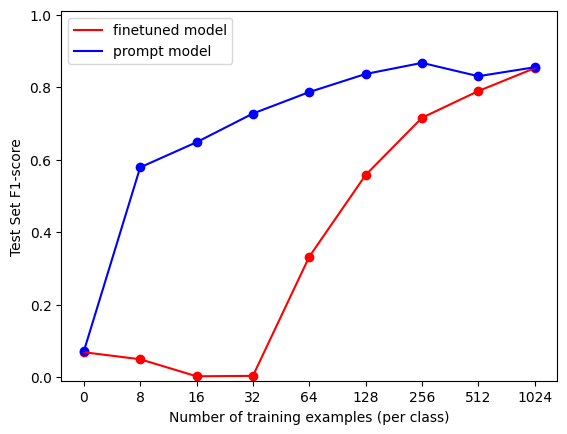

In [ ]:
fig1 = plt.figure()
ax11 = fig1.add_subplot(111)

x = sample_sizes
ax11.plot(range(len(x)), finetune_scores, color='r', label='finetuned model')
ax11.scatter(range(len(x)), finetune_scores, color='r')

ax11.plot(range(len(x)), prompt_scores, color='b', label='prompt model')
ax11.scatter(range(len(x)), prompt_scores, color='b')

ax11.set_xticks(range(len(x)))
ax11.set_xticklabels(x)
ax11.set_ylim(-0.01,1.01)
ax11.set_xlabel('Number of training examples (per class)')
ax11.set_ylabel('Test Set F1-score')
ax11.legend()